### kaggle Titanic dataset deep learning

In [26]:
import functools
import tensorflow as tf
tf.test.is_gpu_available() #https://github.com/tensorflow/tensorflow/issues/38194
import numpy as np
import tensorflow_datasets as tfds
import pandas as pd

In [27]:
TRAIN_DATA_PATH = "./data/train.csv"
TEST_DATA_PATH = "./data/test.csv"

train_data = pd.read_csv(TRAIN_DATA_PATH, header=0)
test_data = pd.read_csv(TEST_DATA_PATH, header=0)

In [28]:
# train_data.dtypes
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
test_data['Survived'] = np.nan
# test_data.head()
test_data = test_data[train_data.columns]
test_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [30]:

data = pd.concat([train_data, test_data], axis=0)

In [31]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [33]:
column_type_dict = data.dtypes.apply(lambda x: x.name).to_dict()

In [34]:
label_column = ["Survived"]

In [35]:
feature_columns = list(set(data.columns) - set(label_column))
dense_feature = list(set(data.select_dtypes(include=np.number).columns) & set(feature_columns))
sparse_feature = list(set(data.select_dtypes(exclude=np.number).columns) & set(feature_columns))
# feature_columns
# dense_feature
sparse_feature

['Embarked', 'Name', 'Sex', 'Cabin', 'Ticket']

In [36]:
%whos

Variable                Type          Data/Info
-----------------------------------------------
LabelEncoder            type          <class 'sklearn.preproces<...>ing._label.LabelEncoder'>
TEST_DATA_PATH          str           ./data/test.csv
TRAIN_DATA_PATH         str           ./data/train.csv
column_type_dict        dict          n=12
concat_dense_inputs     Tensor        Tensor("concatenate_1/con<...>(None, 6), dtype=float32)
data                    DataFrame          PassengerId  Survive<...>n[1309 rows x 12 columns]
data_dense              DataFrame              Fare     SibSp  <...>\n[1309 rows x 6 columns]
data_sparse             DataFrame          Embarked  Name  Sex <...>\n[1309 rows x 5 columns]
dense_feature           list          n=6
dense_inputs            list          n=6
f                       str           Age
feature_columns         list          n=11
fst_order_dense_layer   Tensor        Tensor("dense_1/BiasAdd:0<...>(None, 1), dtype=float32)
functools          

In [37]:
def process_dense_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna(0.0)  # 暂时填充为0
    for f in feats:
        d[f] = d[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    
    return d

In [38]:
data_dense = process_dense_feats(data, dense_feature)
data_dense

,Fare,SibSp,PassengerId,Pclass,Parch,Age
0,2.110213,0.693147,0.693147,1.386294,0.000000,3.135494
1,4.280593,0.693147,1.098612,0.693147,0.000000,3.663562
2,2.188856,0.000000,1.386294,1.386294,0.000000,3.295837
3,3.990834,0.693147,1.609438,0.693147,0.000000,3.583519
4,2.202765,0.000000,1.791759,1.386294,0.000000,3.583519
...,...,...,...,...,...,...
413,2.202765,0.000000,7.174724,1.386294,0.000000,0.000000
414,4.699571,0.000000,7.175490,0.693147,0.000000,3.688879
415,2.110213,0.000000,7.176255,1.386294,0.000000,3.676301
416,2.202765,0.000000,7.177019,1.386294,0.000000,0.000000


In [39]:
from sklearn.preprocessing import LabelEncoder
def process_sparse_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna("-1")  # 默认填充为-1
    for f in feats:
        label_encoder = LabelEncoder()
        d[f] = label_encoder.fit_transform(d[f])
        
    return d

In [40]:
data_sparse = process_sparse_feats(data, sparse_feature)
data_sparse

,Embarked,Name,Sex,Cabin,Ticket
0,3,155,1,0,720
1,1,286,0,107,816
2,3,523,0,0,914
3,3,422,0,71,65
4,3,22,1,0,649
...,...,...,...,...,...
413,3,1126,1,0,711
414,1,891,0,65,834
415,3,1046,1,0,872
416,3,1227,1,0,579


In [41]:
total_data = pd.concat([data_dense, data_sparse], axis=1)
total_data

,Fare,SibSp,PassengerId,Pclass,Parch,Age,Embarked,Name,Sex,Cabin,Ticket
0,2.110213,0.693147,0.693147,1.386294,0.000000,3.135494,3,155,1,0,720
1,4.280593,0.693147,1.098612,0.693147,0.000000,3.663562,1,286,0,107,816
2,2.188856,0.000000,1.386294,1.386294,0.000000,3.295837,3,523,0,0,914
3,3.990834,0.693147,1.609438,0.693147,0.000000,3.583519,3,422,0,71,65
4,2.202765,0.000000,1.791759,1.386294,0.000000,3.583519,3,22,1,0,649
...,...,...,...,...,...,...,...,...,...,...,...
413,2.202765,0.000000,7.174724,1.386294,0.000000,0.000000,3,1126,1,0,711
414,4.699571,0.000000,7.175490,0.693147,0.000000,3.688879,1,891,0,65,834
415,2.110213,0.000000,7.176255,1.386294,0.000000,3.676301,3,1046,1,0,872
416,2.202765,0.000000,7.177019,1.386294,0.000000,0.000000,3,1227,1,0,579


In [42]:
total_data['label'] = data[label_column]

In [43]:
total_data

,Fare,SibSp,PassengerId,Pclass,Parch,Age,Embarked,Name,Sex,Cabin,Ticket,label
0,2.110213,0.693147,0.693147,1.386294,0.000000,3.135494,3,155,1,0,720,0.0
1,4.280593,0.693147,1.098612,0.693147,0.000000,3.663562,1,286,0,107,816,1.0
2,2.188856,0.000000,1.386294,1.386294,0.000000,3.295837,3,523,0,0,914,1.0
3,3.990834,0.693147,1.609438,0.693147,0.000000,3.583519,3,422,0,71,65,1.0
4,2.202765,0.000000,1.791759,1.386294,0.000000,3.583519,3,22,1,0,649,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,2.202765,0.000000,7.174724,1.386294,0.000000,0.000000,3,1126,1,0,711,NaN
414,4.699571,0.000000,7.175490,0.693147,0.000000,3.688879,1,891,0,65,834,NaN
415,2.110213,0.000000,7.176255,1.386294,0.000000,3.676301,3,1046,1,0,872,NaN
416,2.202765,0.000000,7.177019,1.386294,0.000000,0.000000,3,1227,1,0,579,NaN


In [44]:
import tensorflow as tf

In [45]:
dense_inputs = []
for f in dense_feature:
    _input = tf.keras.layers.Input([1], name=f)
    dense_inputs.append(_input)

In [46]:
dense_inputs

[<tf.Tensor 'Fare_1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'SibSp_1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'PassengerId_1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Pclass_1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Parch_1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Age_1:0' shape=(None, 1) dtype=float32>]

In [48]:
# 线性模型
concat_dense_inputs = tf.keras.layers.Concatenate(axis=1)(dense_inputs)
fst_order_dense_layer = tf.keras.layers.Dense(1)(concat_dense_inputs)
liner_model = tf.keras.models.Model(dense_inputs, fst_order_dense_layer)
liner_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Fare (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
SibSp (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
PassengerId (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
Pclass (InputLayer)             [(None, 1)]          0                                            
_______________________________________________________________________________________

In [49]:
sparse_inputs = []
for f in sparse_feature:
    _input = tf.keras.layers.Input([1], name=f)
    sparse_inputs.append(_input)
sparse_inputs

[<tf.Tensor 'Embarked:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Name:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Sex:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Cabin:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Ticket:0' shape=(None, 1) dtype=float32>]

In [50]:
import math
sparse_1d_embed = []
for _input in sparse_inputs:
    f = _input.name.split(':')[0]
    voc_size = data[f].nunique()
    _embed = tf.keras.layers.Flatten(name=f+"_flatten")(tf.keras.layers.Embedding(voc_size+1, 1, embeddings_regularizer=tf.keras.regularizers.l2(0.5))(_input))
    sparse_1d_embed.append(_embed)
sparse_1d_embed

[<tf.Tensor 'Embarked_flatten/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Name_flatten/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Sex_flatten/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Cabin_flatten/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Ticket_flatten/Reshape:0' shape=(None, 1) dtype=float32>]

In [51]:
fst_order_sparse_layer = tf.keras.layers.Add()(sparse_1d_embed)
# tf.keras.models.Model(sparse_inputs, fst_order_sparse_layer).summary()

In [52]:
k = 8
# 只考虑sparse的二阶交叉
sparse_kd_embed = []
for feat, _input in enumerate(sparse_inputs):
    f = sparse_feature[feat]
    voc_size = data[f].nunique()
    _embed = tf.keras.layers.Embedding(voc_size+1, k, embeddings_regularizer=tf.keras.regularizers.l2(0.7))(_input)
    sparse_kd_embed.append(_embed)
sparse_kd_embed

[<tf.Tensor 'embedding_5/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_6/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_7/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_8/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_9/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>]

In [53]:
concat_sparse_kd_embed = tf.keras.layers.Concatenate(axis=1)(sparse_kd_embed) 

In [54]:
import tensorflow.keras.backend as K
sum_kd_embed = tf.keras.layers.Lambda(lambda x: K.sum(x, axis=1))(concat_sparse_kd_embed)  # ?, k
square_sum_kd_embed = tf.keras.layers.Multiply()([sum_kd_embed, sum_kd_embed])  # ?, k

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import *

square_kd_embed = Multiply()([concat_sparse_kd_embed, concat_sparse_kd_embed]) # ?, n, k
sum_square_kd_embed = Lambda(lambda x: K.sum(x, axis=1))(square_kd_embed) 

In [56]:
sub = Subtract()([square_sum_kd_embed, sum_square_kd_embed])
sub = Lambda(lambda x: x*0.5)(sub)
snd_order_sparse_layer = Lambda(lambda x: K.sum(x, axis=1, keepdims=True))(sub)

In [57]:
linear_part = Add()([fst_order_dense_layer, fst_order_sparse_layer])
interaction_part = snd_order_sparse_layer

In [58]:
logits = Add()([linear_part, interaction_part])
output_layer = Activation("sigmoid")(logits)

In [59]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [60]:
model = Model(dense_inputs+sparse_inputs, output_layer)
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Embarked (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
Name (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Sex (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
Cabin (InputLayer)              [(None, 1)]          0                                            
_______________________________________________________________________________________

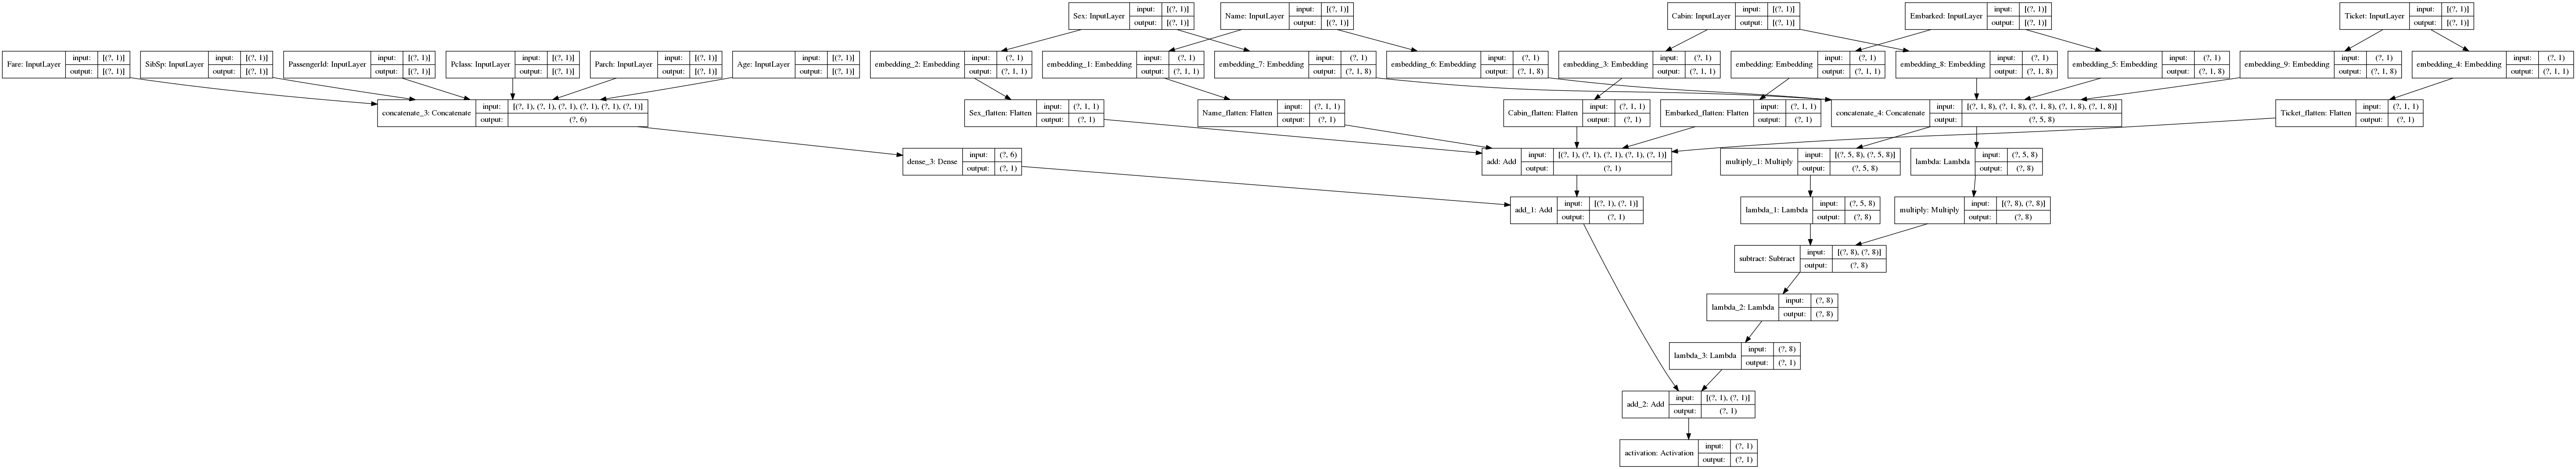

In [61]:
plot_model(model, "fm_model.png", show_shapes=True)

In [62]:
! pip install pydot

Looking in indexes: https://pypi.doubanio.com/simple


In [63]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["binary_crossentropy", tf.keras.metrics.AUC(name='auc')])

In [64]:
from tensorflow.keras.callbacks import TensorBoard

In [65]:
tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

In [66]:
test_data = total_data[total_data["label"].isna()]
train_data = total_data[total_data["label"].notna()]
valid_data = train_data.loc[750:]
train_data = train_data.loc[:750 - 1] # 闭区间

In [67]:
train_dense_x = [train_data[f].values for f in dense_feature]
train_sparse_x = [train_data[f].values for f in sparse_feature]

In [68]:
train_label = [train_data['label'].values]

In [69]:
train_label

[array([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
        0., 

In [70]:
val_dense_x = [valid_data[f].values for f in dense_feature]
val_sparse_x = [valid_data[f].values for f in sparse_feature]

In [71]:
val_label = [valid_data['label'].values]

In [72]:
model.fit(train_dense_x+train_sparse_x, 
          train_label, epochs=50, batch_size=256,
          validation_data=(val_dense_x+val_sparse_x, val_label), 
          callbacks=[tbCallBack])

Epoch 1/50


/home/yons/.pyenv/versions/3.7.4/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1/3 [=========>....................] - ETA: 0s - loss: 13.5734 - binary_crossentropy: 1.1789 - auc: 0.6203WARNING:tensorflow:From /home/yons/.pyenv/versions/3.7.4/envs/py37/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
3/3 [==============================] - 1s 177ms/step - loss: 12.8599 - binary_crossentropy: 1.1662 - auc: 0.6215 - val_loss: 11.5221 - val_binary_crossentropy: 1.2213 - val_auc: 0.6646
Epoch 2/50
3/3 [==============================] - 0s 18ms/step - loss: 10.8375 - binary_crossentropy: 1.1509 - auc: 0.6155 - val_loss: 9.6758 - val_binary_crossentropy: 1.2044 - val_auc: 0.6633
Epoch 3/50
3/3 [==============================] - 0s 19ms/step - loss: 9.0757 - binary_crossentropy: 1.1353 - auc: 0.6168 - val_loss: 8.0813 - val_binary_crossentropy: 1.1876 - val_auc: 0.6629
Epoch 4/50
3

Epoch 40/50
3/3 [==============================] - 0s 17ms/step - loss: 0.7722 - binary_crossentropy: 0.7542 - auc: 0.6414 - val_loss: 0.7801 - val_binary_crossentropy: 0.7621 - val_auc: 0.6819
Epoch 41/50
3/3 [==============================] - 0s 17ms/step - loss: 0.7674 - binary_crossentropy: 0.7494 - auc: 0.6422 - val_loss: 0.7742 - val_binary_crossentropy: 0.7562 - val_auc: 0.6852
Epoch 42/50
3/3 [==============================] - 0s 19ms/step - loss: 0.7628 - binary_crossentropy: 0.7448 - auc: 0.6431 - val_loss: 0.7684 - val_binary_crossentropy: 0.7504 - val_auc: 0.6873
Epoch 43/50
3/3 [==============================] - 0s 18ms/step - loss: 0.7581 - binary_crossentropy: 0.7401 - auc: 0.6436 - val_loss: 0.7629 - val_binary_crossentropy: 0.7449 - val_auc: 0.6864
Epoch 44/50
3/3 [==============================] - 0s 19ms/step - loss: 0.7538 - binary_crossentropy: 0.7358 - auc: 0.6452 - val_loss: 0.7576 - val_binary_crossentropy: 0.7396 - val_auc: 0.6865
Epoch 45/50
3/3 [=============

In [73]:
test_dense_x = [test_data[f].values for f in dense_feature]
test_sparse_x = [test_data[f].values for f in sparse_feature]

In [74]:
pred = model.predict(test_dense_x+test_sparse_x)
# pred.head()

In [75]:
y_pred = [ 1 if i[0] > 0.5 else 0 for i in pred ]
# y = [ 1 if pred[0] > 0.5 else 0 for i in pred ]

In [76]:
y_pred

from pandas.core.frame import DataFrame
c = {"Survived":y_pred #,'b':b
    }  #将列表a，b装换成字典
 
pd_y = DataFrame(c)
print(pd_y)

     Survived
0           0
1           0
2           0
3           0
4           0
..        ...
413         0
414         0
415         0
416         0
417         1

[418 rows x 1 columns]


In [77]:
test_data = pd.read_csv(TEST_DATA_PATH, header=0)
test_data.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [78]:
submission = pd.concat([test_data['PassengerId'], pd_y], axis=1)
submission.to_csv('submission.csv', header=True, index=False)

In [ ]:
! pip install kaggle

In [ ]:
!kaggle competitions submit -c titanic -f submission.csv -m "tensorflow fm"